In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils
import PODutils

from sklearn.manifold import LocallyLinearEmbedding
from time import time
from scipy import interpolate.interp2d

saveFolder = './RNV45-LLEthumbs'

import os
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [2]:
#PIVutils = reload(PIVutils)
X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [3]:
frame = 0

In [4]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

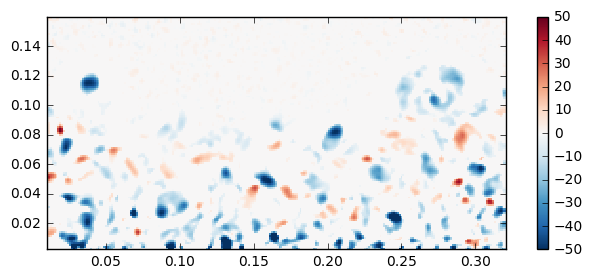

In [5]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(Swirl[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,50)

# Interpolate missing vectors

In [ ]:
for i in range(uSize[2]):
    f = interp2d(X[0,:], Y[:,0], U[:,:,i], kind='linear')
    Temp = f
    U[:,:,i] =

# Remove background noise

In [6]:
Noise = np.std(Swirl,axis=(2,1))
Noise = np.std(Noise[-5:])
print(Noise)

0.243960186268


In [7]:
SwirlFilt = Swirl.copy()    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(Swirl)<20*Noise] = 0

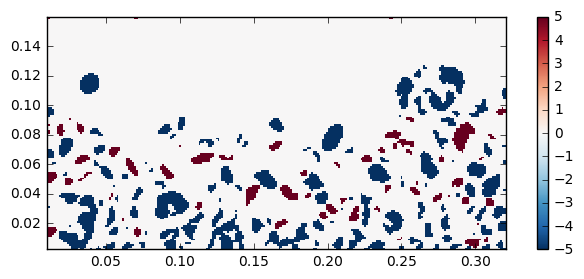

In [8]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,5)

# Normalize field by std

In [9]:
SwirlStd = np.std(Swirl,axis=(2,1))
#print(SwirlStd)

In [10]:
#Normalize field by the std of Swirl
SwirlFilt = SwirlFilt/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

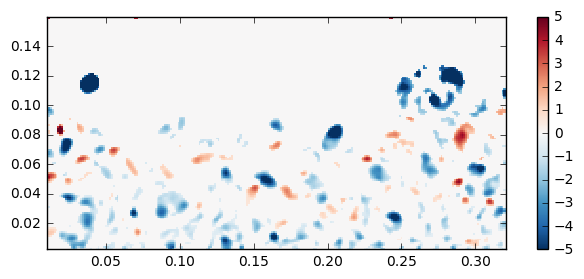

In [11]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

In [12]:
SwirlFiltBackup = SwirlFilt.copy()

# Create thresholded field

In [13]:
SwirlFilt = SwirlFiltBackup.copy()    #think this should completely copy the list, allowing me to try things

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 1.5
SwirlFilt[np.absolute(SwirlFilt)<ThreshSTD] = 0
SwirlFiltPro = SwirlFilt.copy()
SwirlFiltPro[SwirlFiltPro>0] = 0
SwirlFiltRet = SwirlFilt.copy()
SwirlFiltRet[SwirlFiltRet<0] = 0

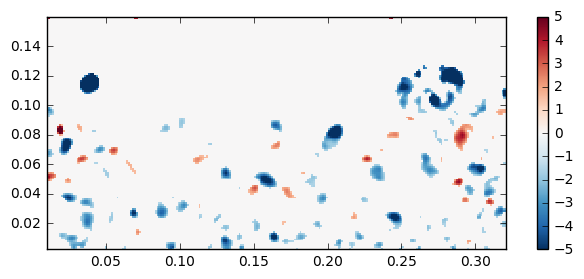

In [14]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

# Find all blobs and filter for size


In [15]:
BoxSize = 10

PIVutils = reload(PIVutils)
ThreshPro = 35    #30 or 35 cause bug
[num_features_Pro,features_per_frame_Pro, labeled_array_Pro, cent_Pro] = PIVutils.findBlobs(SwirlFiltPro,ThreshPro,EdgeBound = BoxSize)

ThreshRet = 20    #30 or 35 cause bug
[num_features_Ret,features_per_frame_Ret, labeled_array_Ret, cent_Ret] = PIVutils.findBlobs(SwirlFiltRet,ThreshRet,EdgeBound = BoxSize)

There are  76730  features identified
A total of  13188  are larger than the threshold size
Of these 10645  are far enough away from edge of domain
There are  27229  features identified
A total of  3924  are larger than the threshold size
Of these 3489  are far enough away from edge of domain


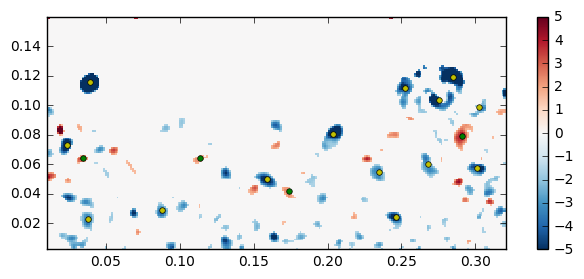

In [16]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

for i in range(features_per_frame_Pro[frame]):
    plt.plot(cent_Pro[frame][i][1]*scale+X[1,1],cent_Pro[frame][i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)
    
for i in range(features_per_frame_Ret[frame]):
    plt.plot(cent_Ret[frame][i][1]*scale+X[1,1],cent_Ret[frame][i][0]*scale+Y[1,1],'og',markersize=4,markeredgecolor=None)

# Subtract mean profile or mean at centroid of swirl blob

In [17]:
#Calculate mean velocity profiles
Umean = np.nanmean(U,axis=(2,1))
Umean
Umean.shape
#print(Umean)

Umean = np.transpose(np.tile(Umean,(uSize[2],uSize[1],1)),(2,1,0))
#print(Umean.shape)

#Subtract mean velocity profiles from velocity fields
Uf = U - Umean;
Vf = V; #<--Mean in vertical is aprox zero
#Wf = W
del Umean

# Get thumbnails (Box = 21x21)

In [18]:
reload(PIVutils)

Ut, Vt, St = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Pro,BoxSize)
features_per_frame_Pro = Ut.shape[2]
Ut2, Vt2, St2 = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Ret,BoxSize)
features_per_frame_Ret = Ut2.shape[2]

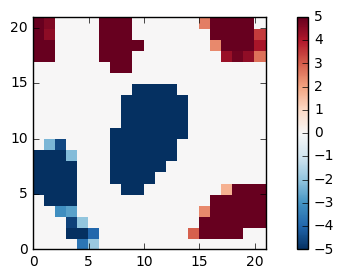

In [19]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=5)

In [20]:
ind = 0
ypos =[]
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        ypos = np.concatenate([ypos, [Y[cent_Pro[i][j][0],1]]])
        
        #[ind] = cent_Pro[i][j][0]*scale+Y[1,1]
        #ind+=1

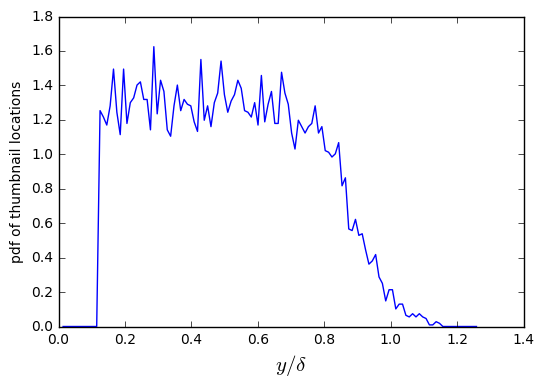

In [21]:
# Calcualte pdf of wall-normal locations
xedges = Y[:,0]/Cond["delta"]
xedges = np.concatenate([[xedges[0]-(xedges[1]-xedges[0])],xedges, [xedges[-1]+xedges[-1]-xedges[-2]]])
p, x = np.histogram(ypos/Cond["delta"], xedges,normed=True)
x = x[:-1] + (x[1] - x[0])/2 
plt.plot(x, p)
plt.xlabel('$y/\delta$', fontsize=15)
plt.ylabel('pdf of thumbnail locations')

In [22]:
ypos = ypos/Cond["delta"]

### Now do a range of different manifold learning on the resulting thumbnails

In [23]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [24]:
ncomp = 4
nneigh = 100

In [25]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0).T
#uAll.shape      

##### Do regular LLE

In [31]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, eigen_solver='dense')
#outLLE = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLE = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

5.272687832514445  mins


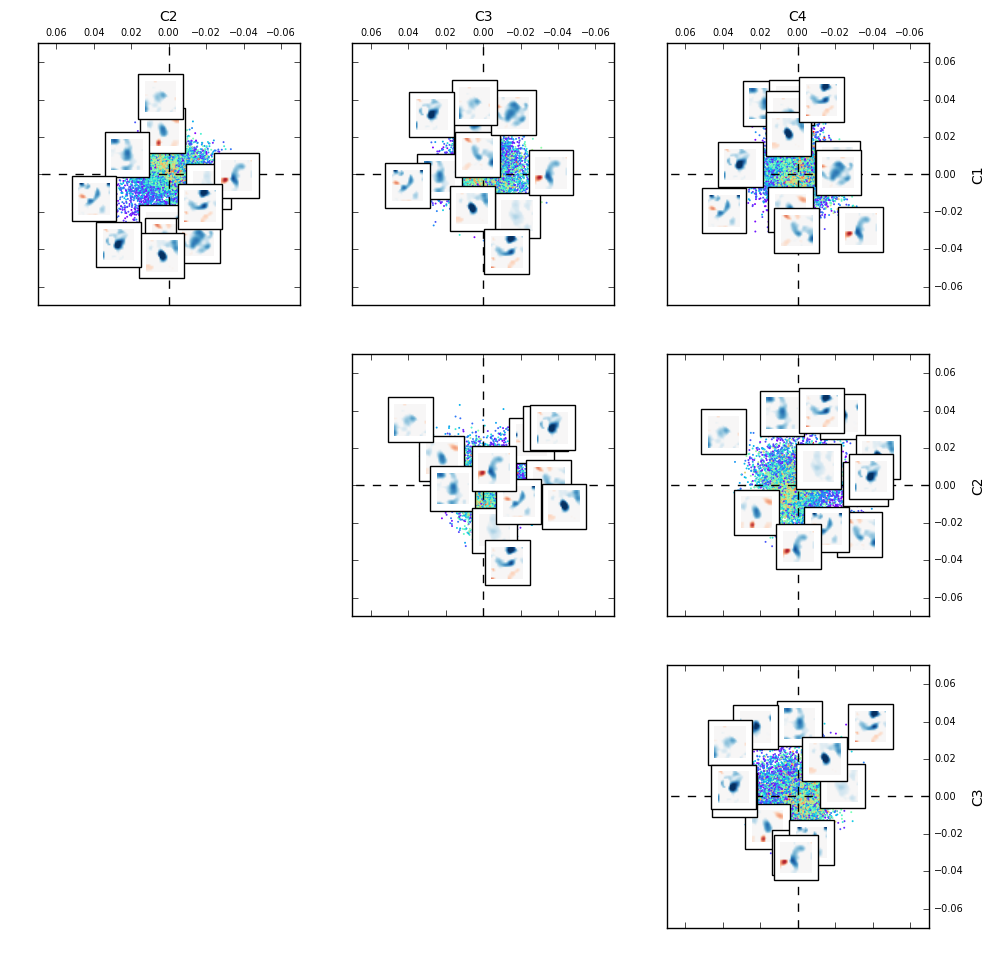

In [32]:
reload(PODutils)
PODutils.plotLLEscatter(outLLE.T,ypos,St,list(range(ncomp)),bound=0.07,thumb_frac=0.4,VecDist=0.01)

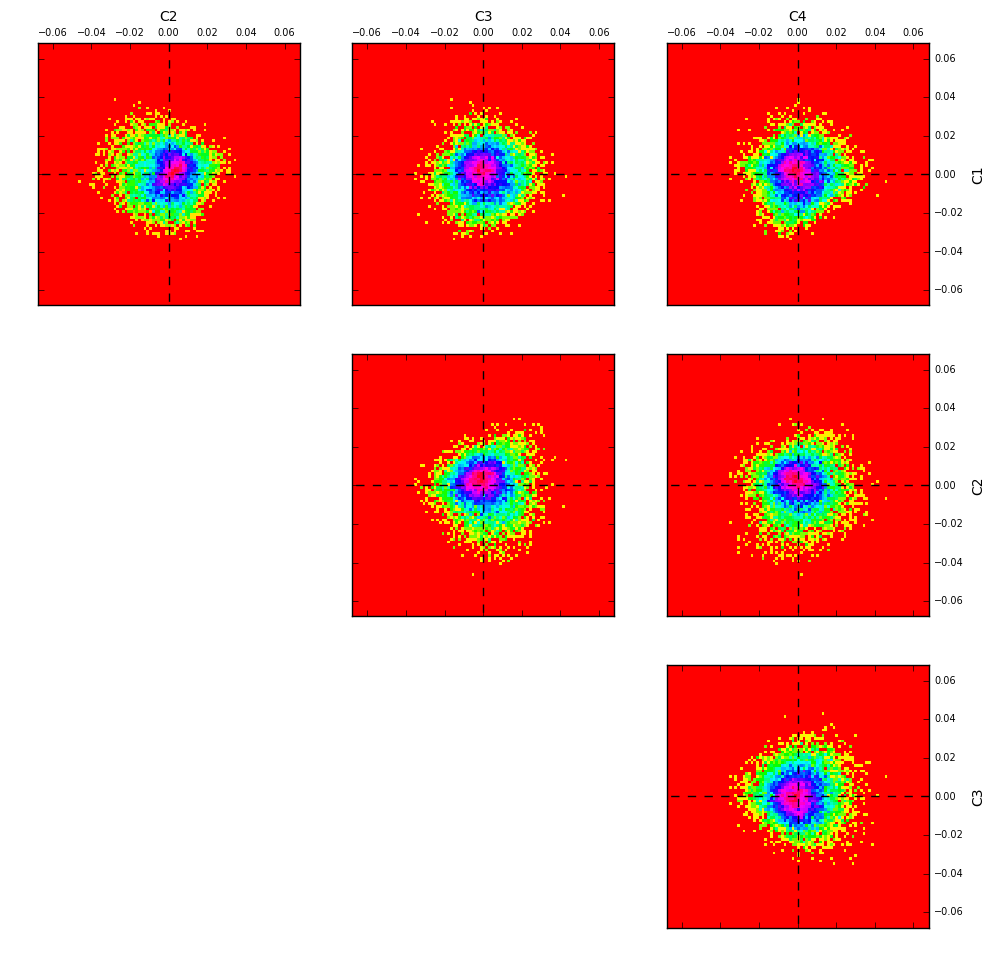

In [33]:
reload(PODutils)
PODutils.plotPODcoeff(outLLE.T,list(range(ncomp)),100,0.07,1)

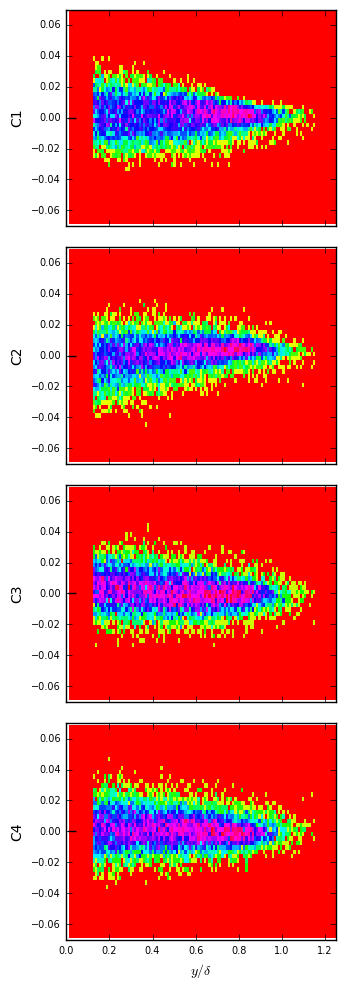

In [34]:
reload(PODutils)
C2 = outLLE.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,0.07,1)

#### Do modified LLE

In [26]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='modified', eigen_solver='dense')
#outLLEmod = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEmod = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

5.642630684375763  mins


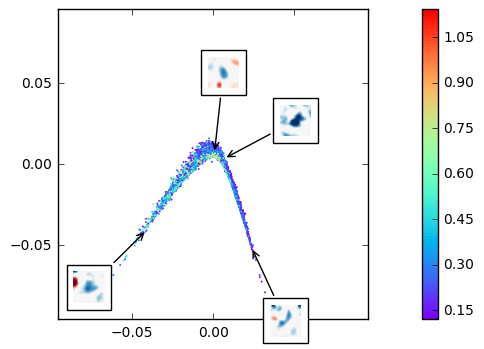

In [27]:
from matplotlib import offsetbox,colors

colorize = dict(c=ypos, cmap=plt.cm.get_cmap('rainbow', 100))
fig, ax = plt.subplots()
h = ax.scatter(outLLEmod[:, 0], outLLEmod[:, 1],s=2, facecolor='0.5', lw = 0, **colorize)
fig.colorbar(h, ax=ax)
plt.axis('scaled')
bound = np.max(np.absolute(outLLEmod))
ax.set_xlim(-1*bound,bound)
ax.set_ylim(-1*bound,bound)

thumb_frac=0.4
cmap='RdBu_r'

min_dist_2 = (thumb_frac * max(outLLEmod.max(0) - outLLEmod.min(0))) ** 2
shown_images = np.array([2 * outLLEmod.max(0)])
for i in range(outLLEmod.shape[0]):
    dist = np.sum((outLLEmod[i] - shown_images) ** 2, 1)
    if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
    shown_images = np.vstack([shown_images, outLLEmod[i]])
    
    vecNorm = (outLLEmod[i,0]**2 + outLLEmod[i,1]**2)**0.5
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(St[:,:,i], cmap=cmap, norm=colors.Normalize(-50,50),zoom=1.5),
                              xybox=0.05*outLLEmod[i,0:2]/vecNorm+outLLEmod[i,0:2],xy=outLLEmod[i,0:2], arrowprops=dict(arrowstyle="->"))
    ax.add_artist(imagebox)
    #imagebox.set_clim([-1*10, 10])

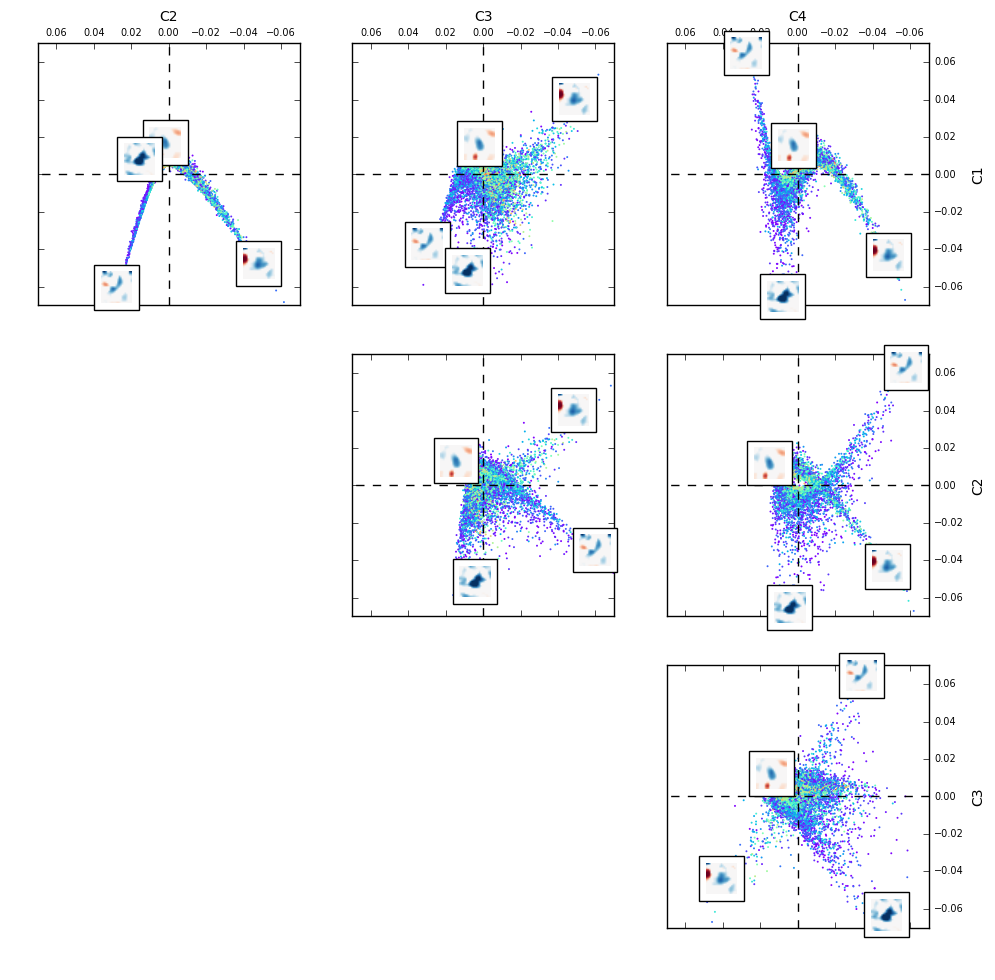

In [28]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEmod.T,ypos,St,list(range(ncomp)),bound=0.07,thumb_frac=0.4,VecDist=0.01,saveFolder=(saveFolder + '/LLEscatter_mod.tif'))

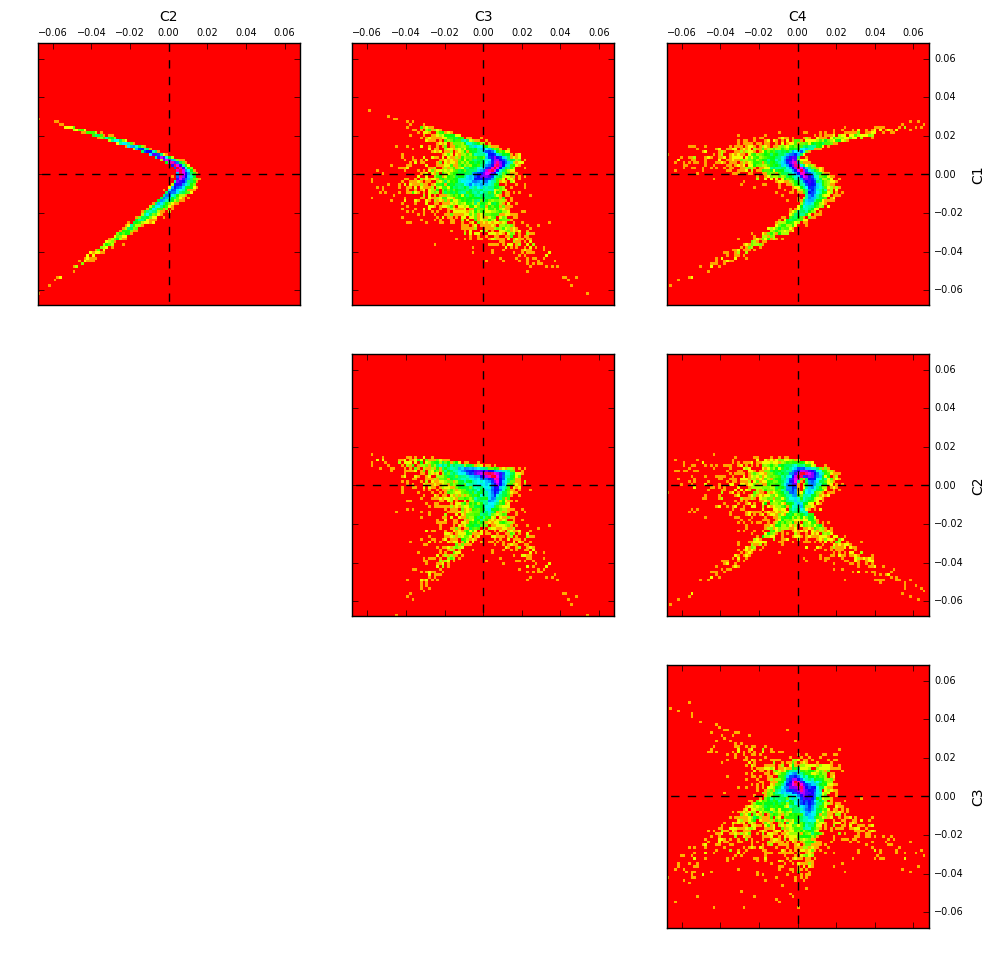

In [29]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEmod.T,list(range(ncomp)),100,0.07,1,saveFolder=(saveFolder + '/Coeff_mod.tif'))

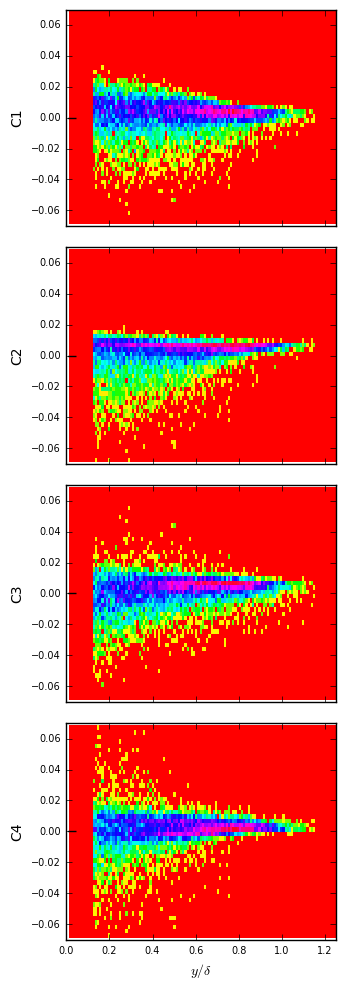

In [30]:
reload(PODutils)
C2 = outLLEmod.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,0.07,1,saveFolder=(saveFolder + '/YposCoeff_mod.tif'))

#### Do Hessian Eigenmaping LLE

In [221]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='hessian', eigen_solver='dense')
#outLLE = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEhes = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

8.170968397458394  mins


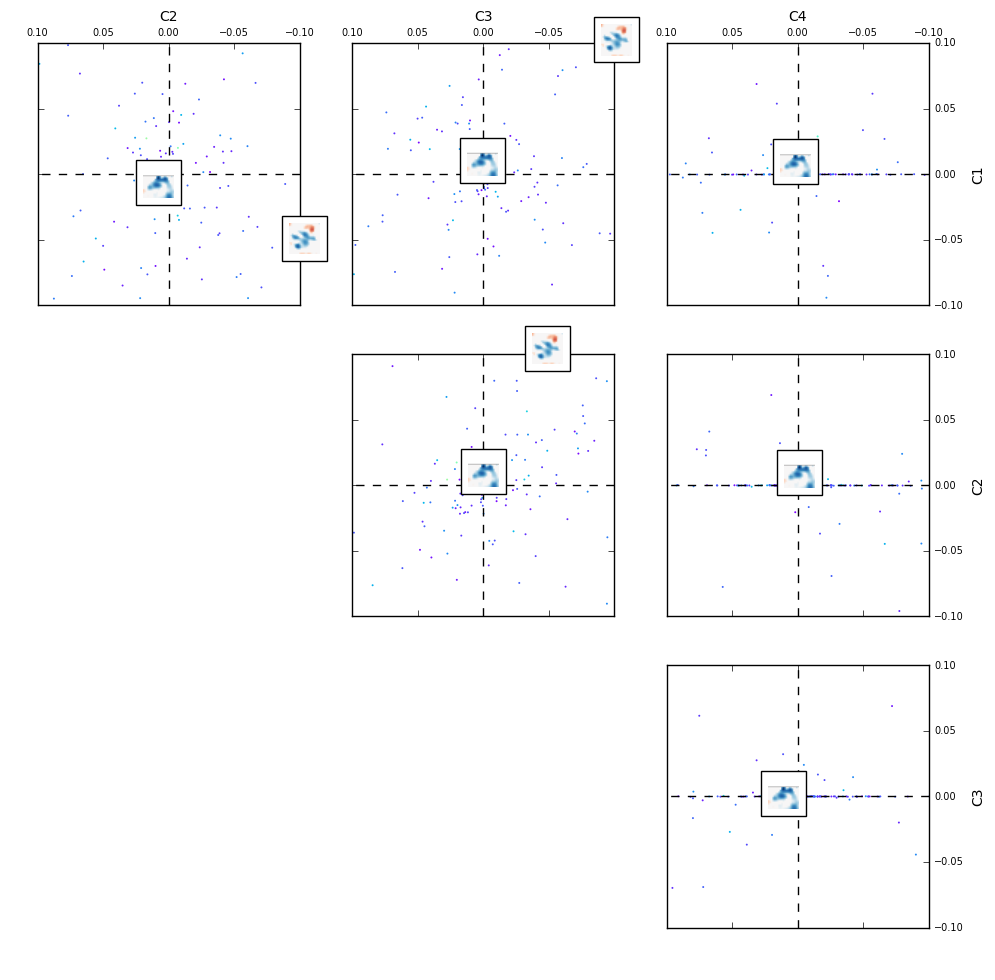

In [229]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEhes.T,ypos,St,list(range(ncomp)),bound=0.1,thumb_frac=0.4,VecDist=0.01)

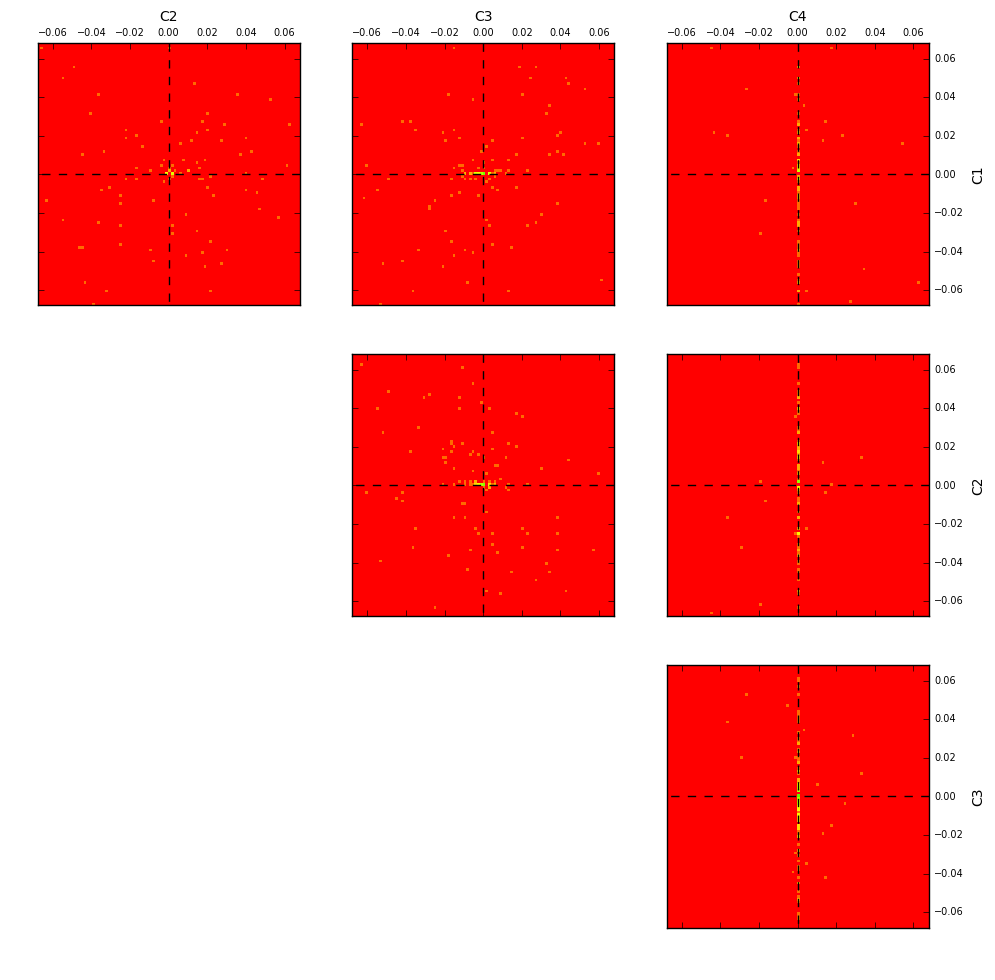

In [223]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEhes.T,list(range(ncomp)),100,0.07,1)

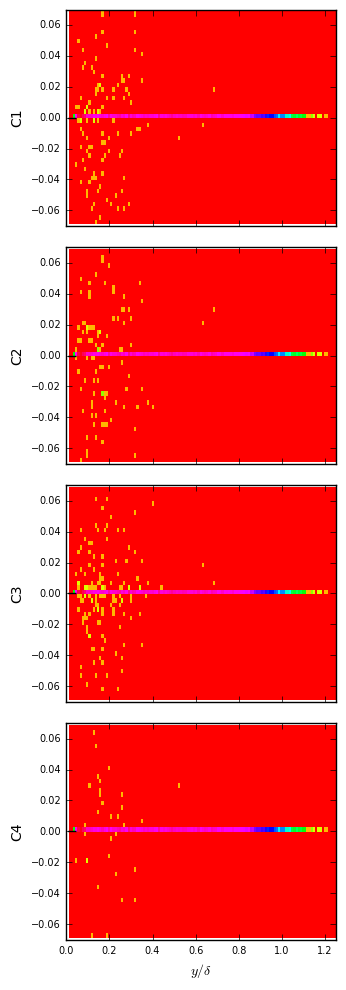

In [224]:
reload(PODutils)
C2 = outLLEhes.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,0.07,1)

#### Do LTSA LLE

In [200]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp,method='ltsa', eigen_solver='dense')
#outLLE = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEltsa = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

8.005308949947358  mins


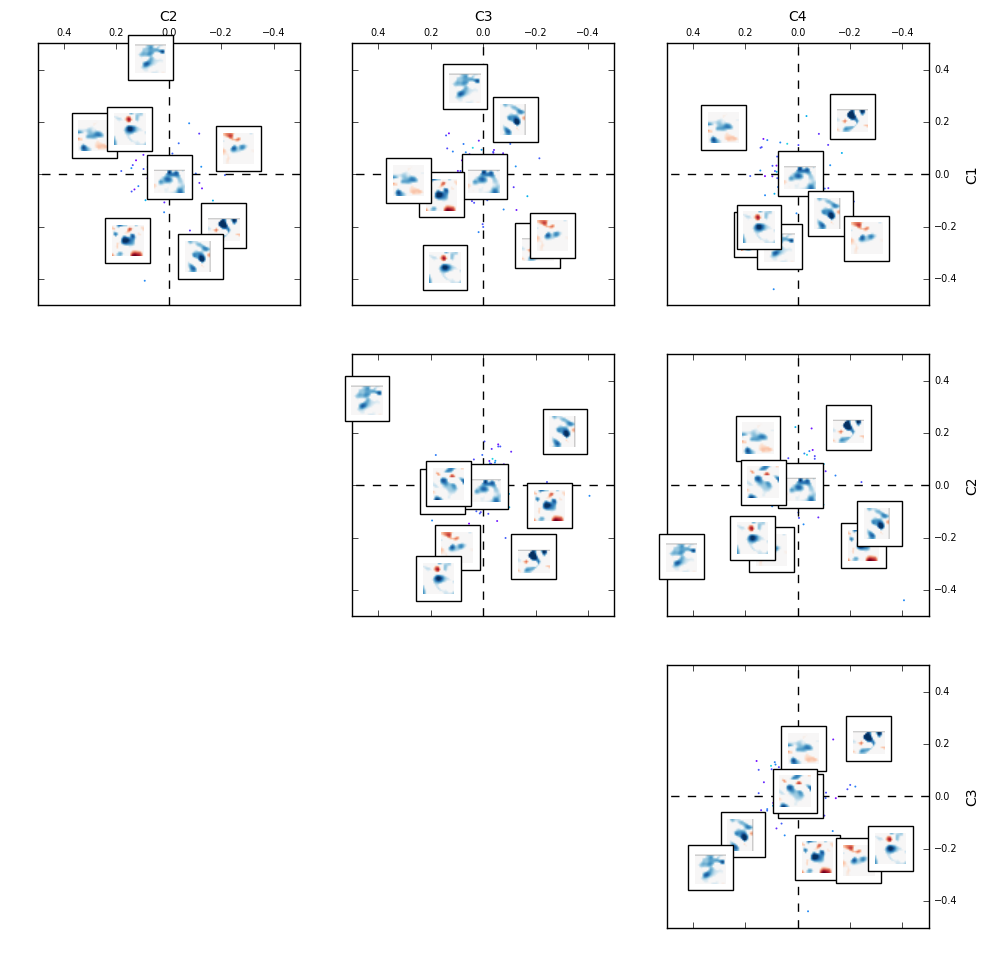

In [213]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEltsa.T,ypos,St,list(range(ncomp)),bound=0.5,thumb_frac=0.4,VecDist=0.01)

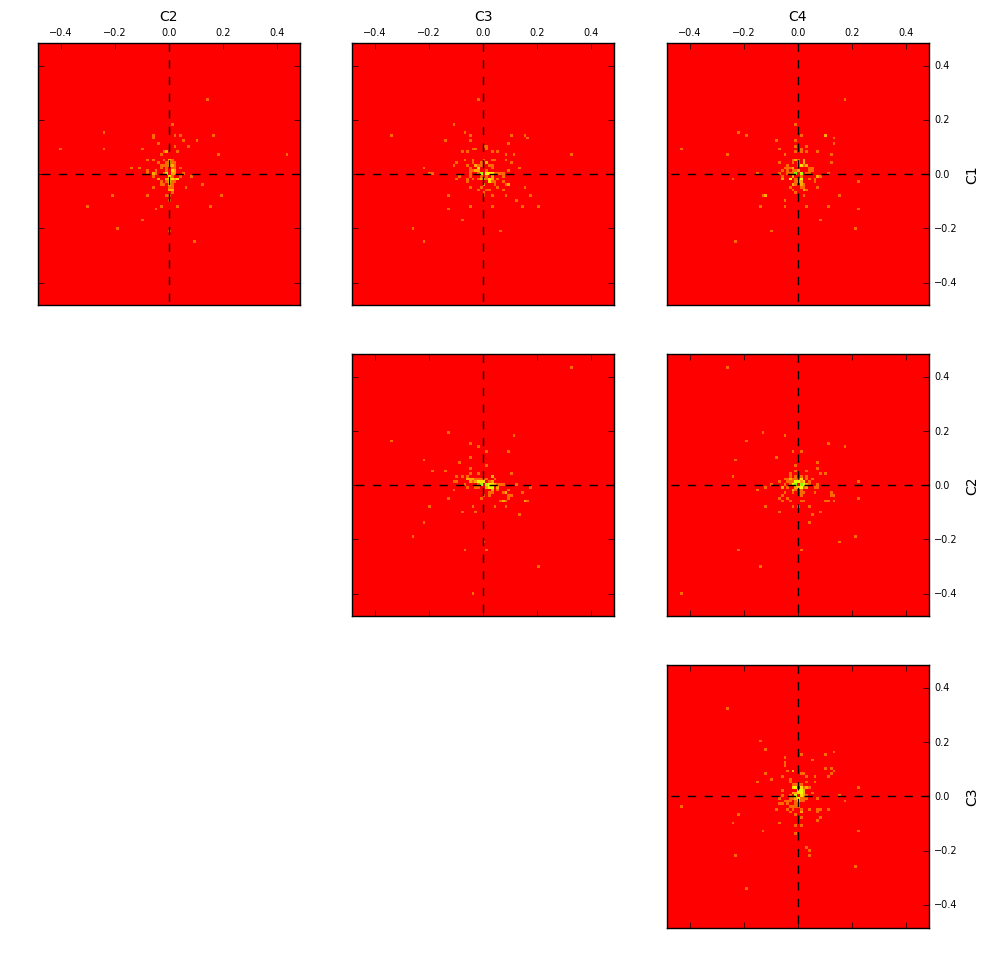

In [219]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEltsa,list(range(ncomp)),100,0.5,1)

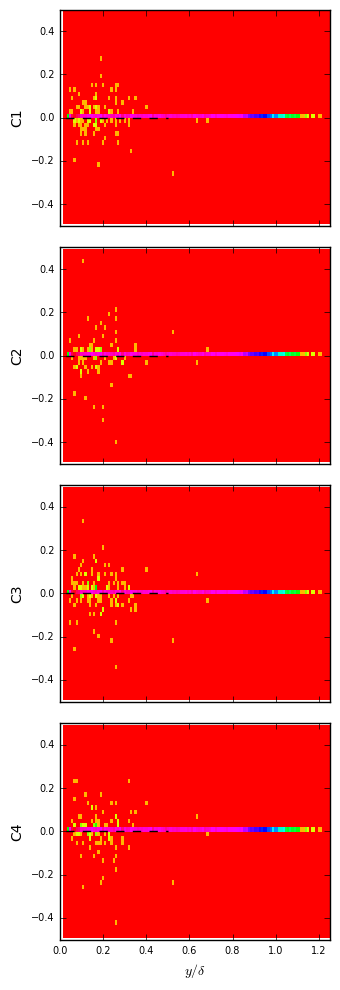

In [220]:
reload(PODutils)
C2 = outLLEltsa.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,0.5,1)

#### Do Isomap 

In [35]:
from sklearn.manifold import Isomap

t0 = time()
model = Isomap(n_components=ncomp)
outIso = model.fit_transform(uAll)
outIso.shape
print((time() - t0)/60, " mins")

4.172406284014384  mins


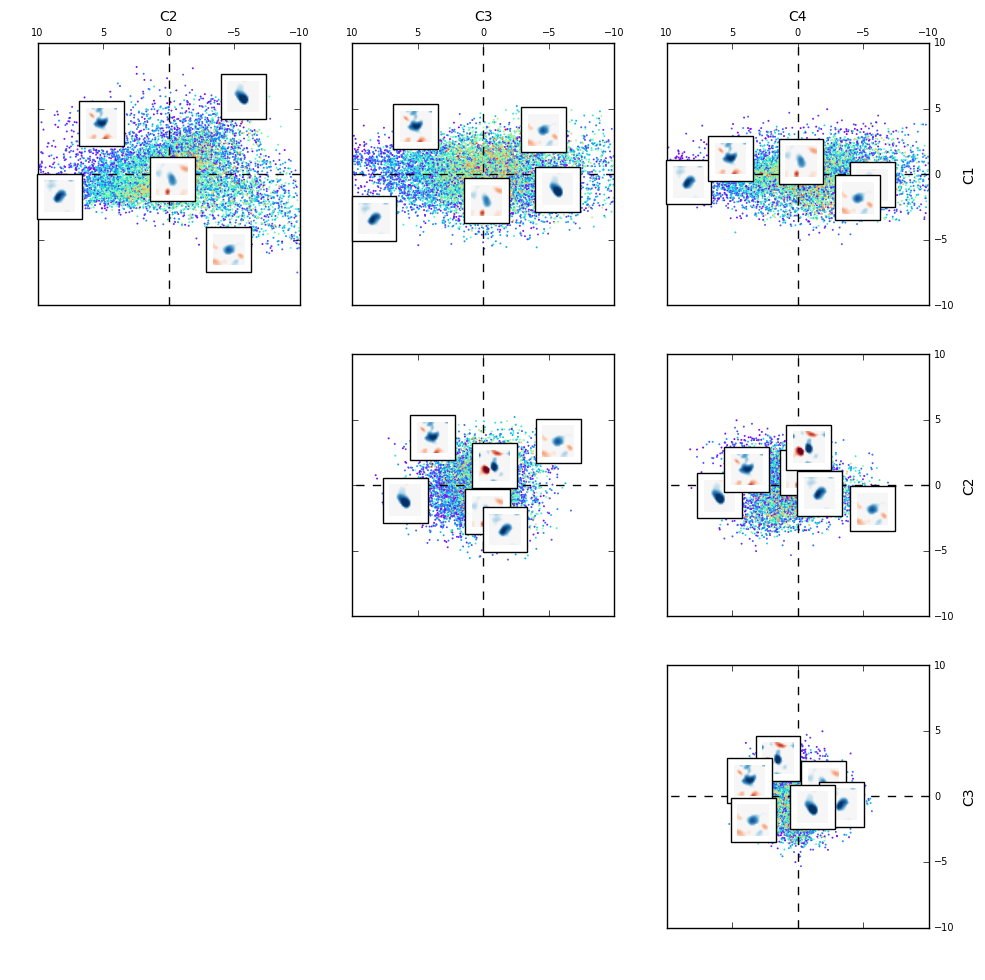

In [36]:
reload(PODutils)
PODutils.plotLLEscatter(outIso.T,ypos,St,list(range(ncomp)),bound=10,thumb_frac=0.3,VecDist=0.01)

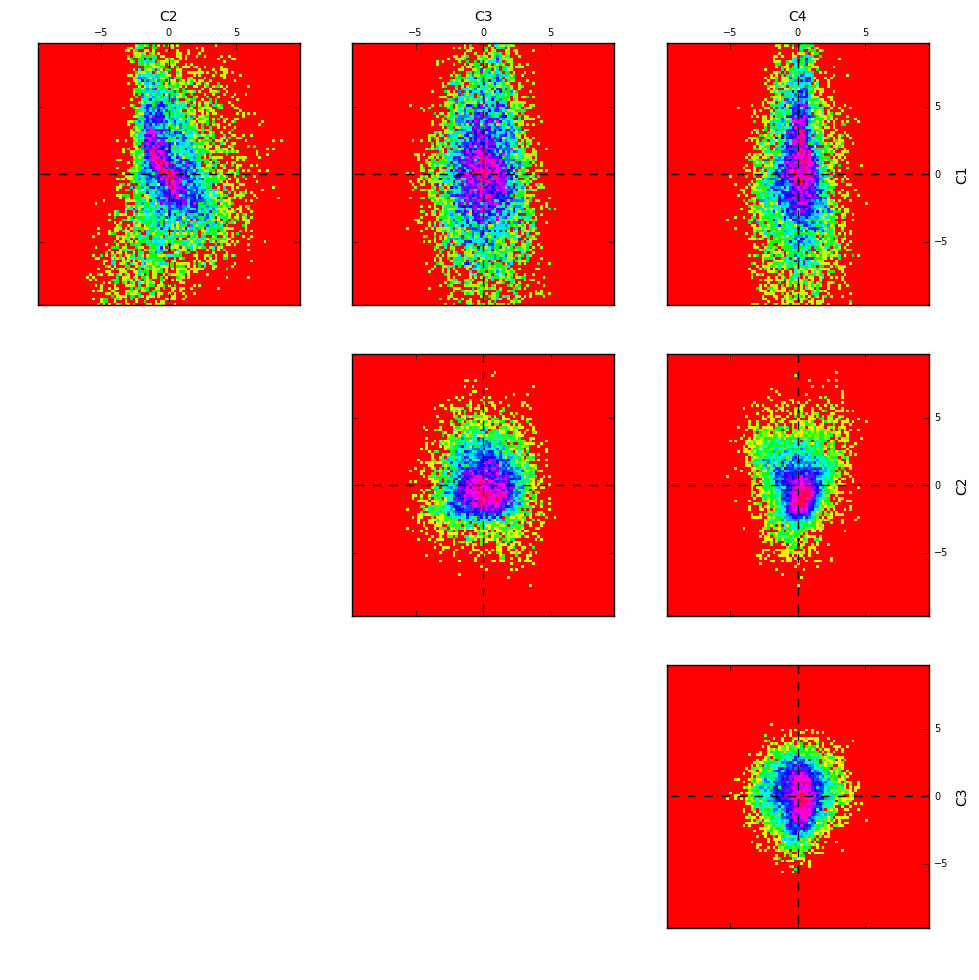

In [37]:
reload(PODutils)
PODutils.plotPODcoeff(outIso.T,list(range(ncomp)),100,10,1)

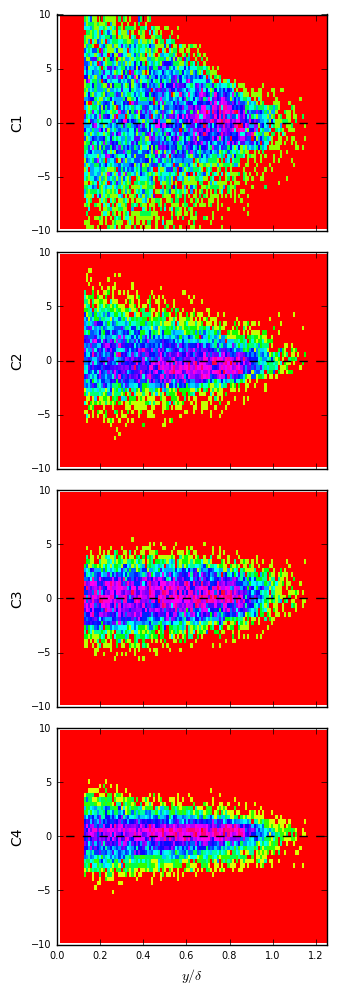

In [38]:
reload(PODutils)
C2 = outIso.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,10,1)

# Test the result on a randomized sample of the data

In [57]:
reload(PIVutils)
BoxSize = 10

Ut, Vt, St = PIVutils.getRandomThumbnails2D(Uf,Vf,Swirl,num_features_Pro,BoxSize)

[ 40 193  15]


### Now do a range of different manifold learning on the resulting thumbnails

In [66]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [67]:
ncomp = 4
nneigh = 50

In [68]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0).T
#uAll.shape      

#### Do modified LLE

In [ ]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='modified', eigen_solver='dense')
#outLLEmod = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEmod = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

In [ ]:
from matplotlib import offsetbox,colors

colorize = dict(c=ypos, cmap=plt.cm.get_cmap('rainbow', 100))
fig, ax = plt.subplots()
h = ax.scatter(outLLEmod[:, 0], outLLEmod[:, 1],s=2, facecolor='0.5', lw = 0, **colorize)
fig.colorbar(h, ax=ax)
plt.axis('scaled')
bound = np.max(np.absolute(outLLEmod))
ax.set_xlim(-1*bound,bound)
ax.set_ylim(-1*bound,bound)

thumb_frac=0.4
cmap='RdBu_r'

min_dist_2 = (thumb_frac * max(outLLEmod.max(0) - outLLEmod.min(0))) ** 2
shown_images = np.array([2 * outLLEmod.max(0)])
for i in range(outLLEmod.shape[0]):
    dist = np.sum((outLLEmod[i] - shown_images) ** 2, 1)
    if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
    shown_images = np.vstack([shown_images, outLLEmod[i]])
    
    vecNorm = (outLLEmod[i,0]**2 + outLLEmod[i,1]**2)**0.5
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(St[:,:,i], cmap=cmap, norm=colors.Normalize(-50,50),zoom=1.5),
                              xybox=0.05*outLLEmod[i,0:2]/vecNorm+outLLEmod[i,0:2],xy=outLLEmod[i,0:2], arrowprops=dict(arrowstyle="->"))
    ax.add_artist(imagebox)
    #imagebox.set_clim([-1*10, 10])

In [ ]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEmod.T,ypos,St,list(range(ncomp)),bound=0.07,thumb_frac=0.4,VecDist=0.01,saveFolder=(saveFolder + '/LLEscatter_mod.tif'))

In [ ]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEmod.T,list(range(ncomp)),100,0.07,1,saveFolder=(saveFolder + '/Coeff_mod.tif'))

In [ ]:
reload(PODutils)
C2 = outLLEmod.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(ncomp)),50,0.07,1,saveFolder=(saveFolder + '/YposCoeff_mod.tif'))